<a href="https://colab.research.google.com/github/SheKJana/first-own-repository/blob/main/Nach_KAQs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Semesteraufgabe BINA- nach KAQs gegliedert**

# Umgebung vorbereiten

In [3]:
#Vorbereitung Blibliotheken und Visualisierungstools hochalde
!pip install scikit-learn
!pip install kaggle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, Markdown


# Daten

Für die Beantwortung unsere Fragen und dem entwickeln des Tools benötigen, wir Daten welche sich dafür eignen.

Datenquelle Bei der Auswahl unserer Datenquellen haben wir uns an folgenden Kriterien orientiert:

- Die Daten mussten die für unsere Fragestellungen relevanten Informationen enthalten, insbesondere Angaben zur individuellen Nährstoffzufuhr und zum Gesundheitszustand.

- Die Daten sollten eine ausreichende Anzahl von Beobachtungen aufweisen, um statistische Analysen (z.B. Clustering) mit gewisser Aussagekraft durchführen zu können.

- Die Struktur der Datensätze sollte grundsätzlich verständlich und weiterverarbeitbar sein – auch wenn wir eine eigene Bereinigung und Aufbereitung vornehmen würden.

Folgende Datensätze von Kaggle haben unsere Anforderungene erfüllt:

**NHANES-Daten**
Ernährungsdaten (diet.csv), Untersuchungsdaten (examination.csv), Diesagnosedaten, Gesundheitsdaten (questionnaire.csv);
Detailed Meals Macros CLEANED und Food and Nutrition
Für den Abgleich mit offiziellen Nährstoffzufuhrs Empfehlungen greifen wir auf die Richtwerte des Bundesamts für Lebensmittelsicherheit und Veterinärwesen
https://www.kaggle.com/datasets/cdc/national-health-and-nutrition-examination-survey


**Food and Nutrition Dataset**

Nährwerte einzelner Lebensmittel (Makros & Mikros)
Ermöglicht detaillierte Aufschlüsselung komplexer Mahlzeiten
https://www.kaggle.com/datasets/utsavdey1410/food-nutrition-dataset/data


Zusätzlich haben wir uns der der offizielen Referentabelle des BLV bedient
(**BLV)**
 Diese gelten als anerkannter Standard in der Schweiz und kommen in der Gesundheitsförderung sowie Ernährungsberatung zum Einsatz. Im Vergleich mit internationalen Richtwerten der WHO stimmen die grundlegenden Zielwerte weitgehend überein.
https://www.blv.admin.ch/blv/de/home/lebensmittel-und-ernaehrung/ernaehrung/empfehlungen-informationen/naehrstoffe/naehrstoffzufuhr-dynamische-tabelle.html

In [57]:
#NHANES (aus Kaggel Quelle) hochladen und zusammenführen
# NHANES (aus Kaggle-Quelle) hochladen und zusammenführen

# BLOCK 1 – NHANES laden & zusammenführen  (mit allen gewünschten Spalten)
import pandas as pd

# -------------------------------------------------
# 1. CSVs laden
base = "https://raw.githubusercontent.com/iceangel79/MScWinf_Gruppenarbeit_Sem2/refs/heads/main/Semesterarbeit/Datasets/Kaggle/"
diet          = pd.read_csv(base + "diet.csv")
examination   = pd.read_csv(base + "examination.csv")
questionnaire = pd.read_csv(base + "questionnaire.csv")
demographic   = pd.read_csv(base + "demographic.csv")

# -------------------------------------------------
# 2. **EXAKT die Spalten, die du genannt hast**  (+ BMXWT als neue Ergänzung)
diet_cols = [
    'SEQN',             # ID
    'DR1TKCAL',         # Kalorien
    'DR1TTFAT',         # Gesamtfett
    'DR1TPROT',         # Eiweiss/Protein
    'DR1TSODI',         # Natrium
    'DR1TSUGR'          # Zucker
]

examination_cols = [
    'SEQN',
    'BMXBMI',           # BMI
    'BMXWT',            # **Gewicht (kg) – neu, für Protein-Vergleich**
    'BPXSY1',           # systolischer Blutdruck
    'BPXDI1'            # diastolischer Blutdruck
]

questionnaire_cols = [
    'SEQN', 'DIQ010', 'BPQ020', 'BPQ030', 'BPQ050A', 'BPQ080', 'BPQ090D',
    'MCQ080', 'MCQ220',
    'PAD615', 'DID040', 'DIQ160', 'DIQ170',
    'WHD010', 'WHD020',
    'DED120', 'DED125',
    'MCQ086',
    'HIQ011', 'HUQ010',
    'SMD460', 'SMAQUEX2', 'SMDANY', 'SMQ710', 'SMQ621',
    'IND235', 'INDFMMPC',
    'CBQ596', 'CBQ611',
    'DBD910', 'CBD070',
    'ALQ110', 'ALQ120Q', 'ALQ151',
    'FSD032C', 'FSD151'
]

demographic_cols = [
    'SEQN',
    'RIDAGEYR',    # Alter
    'RIAGENDR',    # Geschlecht
    'INDHHIN2',    # Haushaltseinkommen
    'INDFMPIR',    # Armutsverhältnis
    'DMDEDUC2',    # Bildungsniveau
    'DMDMARTL',    # Familienstand
    'RIDEXPRG'     # Schwangerschaftsstatus
]

# -------------------------------------------------
# 3. Spalten auswählen
diet_small          = diet[diet_cols]
examination_small   = examination[examination_cols]
questionnaire_small = questionnaire[questionnaire_cols]
demographic_small   = demographic[demographic_cols]

# -------------------------------------------------
# 4. Merge
df_raw = (
    diet_small
        .merge(examination_small,   on="SEQN", how="left")
        .merge(questionnaire_small, on="SEQN", how="left")
        .merge(demographic_small,   on="SEQN", how="left")
)

print("NHANES raw shape:", df_raw.shape)


NHANES raw shape: (9813, 52)


## Must-have und semi-must have definieren
Aufgrund des grossen Datenverlust -40%, wenn festlegen dass mindesten 8 vordefineirte Variablen (Alter, Geschelcht, Grösse, BMI, Kalorien, Natrium und Fett) zu 100% vorhanden sein müssen,  haben wir uns entscheiden die nur **zwei Variablen als absolut zwingend zu klassifizieren. Alter + Geschlecht.** Denn ohne dies ist Berechnung der Differenz von empfohlenere Tageszufuhr und effektiver gar nicht möglich, da wir den Bedarf nicht eruieren könnne.

Bei **4 weiteren müssen mindesten 2 von 4 vorhanden** sein.
Kalorien

- Kalorien
- Natrium
- Fett
- Kohlenhydrate

Dadurch reduzieren wir unsere Datensatz statt um 40% um nur ca. 13%.

In [58]:
# BLOCK 2 – Pflichtfeld-Check
absolute_must_have  = ['RIDAGEYR', 'RIAGENDR']
relative_must_have  = ['DR1TKCAL', 'DR1TSODI', 'DR1TSUGR', 'DR1TTFAT', 'DR1TPROT']
relative_must_have  = [c for c in relative_must_have if c in df_raw.columns]

# 1. Absolut-Kriterium
absolut_ok = df_raw[absolute_must_have].notna().all(axis=1)

# 2. Relativ-Kriterium (≥ 2 von 5)
relativ_ok = df_raw[relative_must_have].notna().sum(axis=1) >= 2

# 3. Filtern
df_bereinigt = df_raw[absolut_ok & relativ_ok].copy()
print(f"Behalten: {len(df_bereinigt)}  |  Entfernt: {len(df_raw) - len(df_bereinigt)}")
df_plot = df_bereinigt.copy()

Behalten: 8531  |  Entfernt: 1282


**BLV Tabelle laden**

RuntimeError: Spalte für PAL nicht gefunden (('physical', 'activity'))

In [78]:
# BLOCK 3  –  BLV-Tabelle laden, PAL aus kcal-Rang ableiten,
#             Alters­bereiche in Einzeljahre auflösen
# Ergebnis:  df_blv_final  mit Spalten:
#   sex | age_years | pal | energy_kcal | fat_pct_tei | sodium_g
# ----------------------------------------------------------------
import pandas as pd, re, numpy as np

url = ("https://github.com/iceangel79/MScWinf_Gruppenarbeit_Sem2/"
       "raw/refs/heads/main/Semesterarbeit/Datasets/BLV/"
       "Nutrient_requirements_CH%20-%202022.xlsx")

# 1)  Datei ohne Header laden
df_tmp = pd.read_excel(url, sheet_name="nutrients", header=None)

# 2)  Kopfzeile automatisch suchen (enthält 'sex' & 'age')
header_idx = next(
    (i for i in range(20)
     if {'sex','age'} <= set(df_tmp.iloc[i].astype(str).str.lower())),
    None
)
if header_idx is None:
    raise RuntimeError("Header-Zeile nicht gefunden")

df_raw = df_tmp.copy()
df_raw.columns = df_raw.iloc[header_idx]
df_raw = df_raw.drop(index=range(header_idx+1)).reset_index(drop=True)

# 3)  Pflicht­spalten aufsammeln
def find_col(keys):
    hits = [c for c in df_raw.columns
            if all(k.lower() in str(c).lower() for k in keys)]
    return hits[0] if hits else None

col_sex      = find_col(('sex',))
col_age      = find_col(('age',))
col_energy   = find_col(('energy','kcal'))
col_fat_pct  = find_col(('fat','%'))
col_sodium_g = find_col(('sodium','g'))

df_blv = df_raw[[col_sex,col_age,col_energy,col_fat_pct,col_sodium_g]].rename(
    columns={ col_sex:'sex', col_age:'age',
              col_energy:'energy_kcal', col_fat_pct:'fat_pct_tei',
              col_sodium_g:'sodium_g' }
)

# 4)  Bereich-Strings in float gießen
def parse_num(v):
    if isinstance(v,str) and any(sep in v for sep in ('to','–','-','—')):
        nums = re.split(r'to|–|-|—',v); nums=[float(n) for n in nums if n.strip()]
        return max(nums)
    try: return float(v)
    except: return np.nan

df_blv['energy_kcal_val'] = df_blv['energy_kcal'].apply(parse_num)
df_blv['fat_pct_val']     = df_blv['fat_pct_tei'].apply(parse_num)
df_blv['sodium_g_val']    = df_blv['sodium_g'].apply(parse_num)

# 5)  PAL ableiten:  pro (sex, age) nach kcal sortieren → low / moderate / high
df_blv = (
    df_blv
      .sort_values(['sex','age','energy_kcal_val'])
      .assign(pal_rank=lambda d: d.groupby(['sex','age']).cumcount())
      .assign(pal=lambda d: d['pal_rank'].map({0:'low',1:'moderate',2:'high'})
                        .fillna('moderate'))
)

# 6)  Alters­bereiche explodieren → Einzeljahre
def explode_age(sex, pal, expr):
    txt=str(expr).lower().replace('–',' to ').replace('—',' to ').replace('-',' to ')
    if any(k in txt for k in ('pregnancy','lactation')): return []
    if 'to' in txt:
        s,e=[p.strip() for p in txt.split('to')]
        s=float(re.sub('[^0-9.]','',s))/(12 if 'm' in s else 1)
        e=float(re.sub('[^0-9.]','',e))/(12 if 'm' in e else 1)
        yrs=range(int(s),int(e)+1)
    elif txt.startswith('>'):
        yrs=range(int(re.sub('[^0-9]','',txt))+1,91)
    else:
        v=float(re.sub('[^0-9.]','',txt)); v/=12 if 'm' in txt else v
        yrs=[int(v)]
    return [{'sex':sex.lower(),'age_years':y,'pal':pal} for y in yrs]

records=[]
for _,r in df_blv.iterrows():
    for base in explode_age(r['sex'],r['pal'],r['age']):
        base.update({
            'energy_kcal': r['energy_kcal_val'],
            'fat_pct_tei': r['fat_pct_val'],
            'sodium_g'   : r['sodium_g_val']
        })
        records.append(base)

df_blv_final = (
    pd.DataFrame(records)
      .astype({'age_years':int})
      .drop_duplicates(['sex','age_years','pal'])
      .sort_values(['sex','age_years','pal'])
)

print("BLV final:", df_blv_final.shape)   #  ≈ 546 (91×2×3)


BLV final: (244, 6)


# **Datensätz verstehen und bereiningen**
Wir prüfen den NHANES Datensatz auf mögliche Ausreisser oder sonstige Angaben die allfällig bereinigt werden müssen.

In [60]:
print([name for name in globals() if name.startswith('df_')])

['df_raw', 'df_analysis', 'df_blv_final', 'df_bereinigt', 'df_plot', 'df_blv_raw', 'df_tmp', 'df_blv']



--- Kalorien (DR1TKCAL) ---
Q1 (25 %): 1281.25
Q3 (75 %): 2194.75
IQR     : 913.50
Min     : 117.00
Max     : 6689.00
Ausreißer oben  (>3565.0): 134
Ausreißer unten (<-89.0): 0


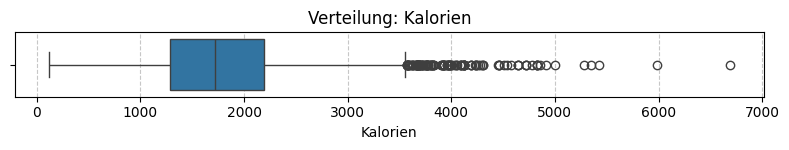


--- Fett (g) (DR1TTFAT) ---
Q1 (25 %): 42.53
Q3 (75 %): 86.55
IQR     : 44.02
Min     : 0.00
Max     : 268.91
Ausreißer oben  (>152.6): 215
Ausreißer unten (<-23.5): 0


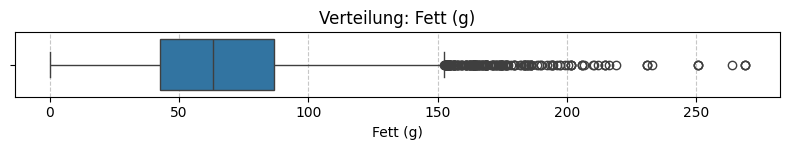


--- Eiweiss (g) (DR1TPROT) ---
Q1 (25 %): 44.75
Q3 (75 %): 86.47
IQR     : 41.72
Min     : 0.00
Max     : 329.42
Ausreißer oben  (>149.0): 256
Ausreißer unten (<-17.8): 0


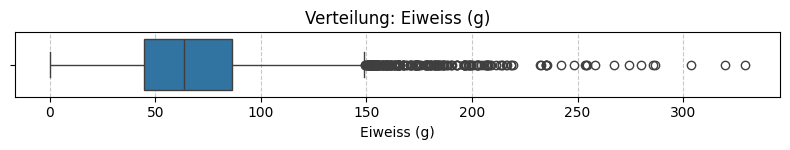


--- Natrium (mg) (DR1TSODI) ---
Q1 (25 %): 1945.00
Q3 (75 %): 3688.75
IQR     : 1743.75
Min     : 17.00
Max     : 21004.00
Ausreißer oben  (>6304.4): 240
Ausreißer unten (<-670.6): 0


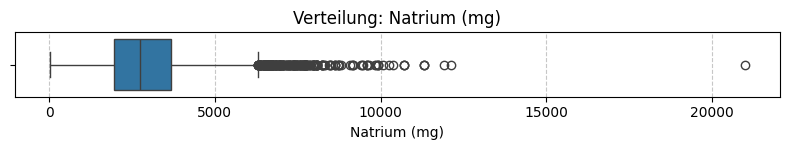


--- Zucker (g) (DR1TSUGR) ---
Q1 (25 %): 57.39
Q3 (75 %): 126.67
IQR     : 69.28
Min     : 0.13
Max     : 835.70
Ausreißer oben  (>230.6): 377
Ausreißer unten (<-46.5): 0


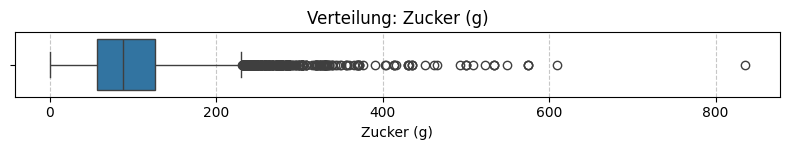

In [77]:
#Codeblock 4
# BLOCK 4 – explorative Verteilung & Boxplots
import matplotlib.pyplot as plt
import seaborn as sns

df_plot = df_bereinigt.copy()

variablen = {
    'DR1TKCAL': 'Kalorien',
    'DR1TTFAT': 'Fett (g)',
    'DR1TPROT': 'Eiweiss (g)',
    'DR1TSODI': 'Natrium (mg)',
    'DR1TSUGR': 'Zucker (g)'
}

df_plot = df_final.copy()        # <<– finaler Bereinigungsstand

for var, beschreibung in variablen.items():
    werte = df_plot[var].dropna()
    q1, q3 = werte.quantile([.25, .75])
    iqr = q3 - q1
    upper_whisk = q3 + 1.5 * iqr
    lower_whisk = q1 - 1.5 * iqr

    print(f"\n--- {beschreibung} ({var}) ---")
    print(f"Q1 (25 %): {q1:.2f}")
    print(f"Q3 (75 %): {q3:.2f}")
    print(f"IQR     : {iqr:.2f}")
    print(f"Min     : {werte.min():.2f}")
    print(f"Max     : {werte.max():.2f}")
    print(f"Ausreißer oben  (>{upper_whisk:.1f}): {(werte > upper_whisk).sum()}")
    print(f"Ausreißer unten (<{lower_whisk:.1f}): {(werte < lower_whisk).sum()}")

    plt.figure(figsize=(8, 1.6))
    sns.boxplot(x=werte)                    # bei Bedarf color='skyblue' löschen
    plt.title(f"Verteilung: {beschreibung}")
    plt.xlabel(beschreibung)
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


**Bereinigung der Variabel Kalorien**
Da alles was über 4000 Kalorien am Tag herausgeht, eher unüblich ist und biologisch gesehen auch eher unrealistisch, müssen wir dies genauer prüfen.

| Aktivitätslevel                                         | Kalorien (kcal) | Protein (g) | Fett (g) | Natrium (mg) |
|---------------------------------------------------------|-----------------|-------------|----------|--------------|
| Sedentär (kaum Bewegung, Büroarbeit)                    | 1800            | 55          | 60       | 2000         |
| Leicht aktiv (1–2x Sport/Woche)                         | 2200            | 70          | 75       | 2300         |
| Mittel aktiv (3–5x Sport/Woche)                         | 2600            | 90          | 90       | 2500         |
| Sehr aktiv (z. B. tägliches Training, Bauarbeiter)      | 3200            | 120         | 110      | 3000         |
| Extrem aktiv (Triathlon, starke Hitze, Tropen)          | 4000            | 150         | 140      | 4000         |


| Kategorie            | BMI (kg/m²)     |
|----------------------|----------------|
| Untergewicht         | < 18.5         |
| Normalgewicht        | 18.5 – 24.9    |
| Übergewicht          | 25.0 – 29.9    |
| Adipositas Grad I    | 30.0 – 34.9    |
| Adipositas Grad II   | 35.0 – 39.9    |
| Adipositas Grad III  | ≥ 40.0         |



In [79]:
# BLOCK 5  –  Merge NHANES + BLV (inkl. PAL)  → df_merged
# ---------------------------------------------------------
PUFFER = 1.15

# 1)  PAL aus PAD615 (min moderate Aktivität/Woche)
def classify_pal(min_week):
    if pd.isna(min_week):  return 'moderate'
    if min_week < 150:     return 'low'
    if min_week <= 300:    return 'moderate'
    return 'high'

df_bereinigt = df_bereinigt.copy()
df_bereinigt['sex']       = df_bereinigt['RIAGENDR'].map({1:'male',2:'female'})
df_bereinigt['age_years'] = df_bereinigt['RIDAGEYR'].round().astype(int)
df_bereinigt['pal']       = df_bereinigt['PAD615'].apply(classify_pal)

# 2)  Merge – Schlüssel: sex + age_years + pal
df_merged = df_bereinigt.merge(
    df_blv_final,
    how='left',
    on=['sex','age_years','pal']
)
assert not df_merged['SEQN'].duplicated().any()

# 3)  Referenz-Grenzen
df_merged['fat_max_g']     = df_merged['energy_kcal']*df_merged['fat_pct_tei']/100/9
df_merged['protein_max_g'] = 1.2*df_merged['BMXWT']
df_merged['sodium_max_mg'] = df_merged['sodium_g']*1000

# 4)  Grundbedarf-Flags
df_merged['kalorien_ok'] = df_merged['DR1TKCAL'] <= df_merged['energy_kcal']*PUFFER
df_merged['fett_ok']     = df_merged['DR1TTFAT'] <= df_merged['fat_max_g']  *PUFFER
df_merged['natrium_ok']  = df_merged['DR1TSODI'] <= df_merged['sodium_max_mg']*PUFFER
df_merged['protein_ok']  = df_merged['DR1TPROT'] <= df_merged['protein_max_g']*PUFFER

# 5)  Kalorien-Outlier (85-Perzentil)
kal_p85 = df_merged['DR1TKCAL'].quantile(0.85)
df_merged['kalorien_outlier_85'] = df_merged['DR1TKCAL'] > kal_p85

# 6)  Wer muss Aktivitäts-/BMI-Plausibilität bestehen?
df_merged['prüfen_aktivität'] = (
      (~df_merged['kalorien_ok']) &
       df_merged['kalorien_outlier_85']
)

print("Merge fertig  |  Zeilen:", len(df_merged),
      "|  zu prüfen:", df_merged['prüfen_aktivität'].sum())


Merge fertig  |  Zeilen: 8531 |  zu prüfen: 1259


In [95]:
# BLOCK 6 – BMI- & Aktivitäts-Plausibilität
# --------------------------------------------------
# Voraussetzung: df_merged  (Block 5)
# Ergebnis     : df_final   – endgültig bereinigt

AKTIV_SCHWELLE = 420       # min/Woche  (≈ 60 min/Tag)
BMI_REF       = 23

df_work = df_merged.copy()

# -------------------------------------------------
# 1) Nur “kritische” Personen (Flag prüfen_aktivität == True)
krit = df_work[df_work['prüfen_aktivität']].copy()

# -------------------------------------------------
# 2) Erwarteten Mindest-BMI aus Kalorienfaktor ableiten
krit['kalorien_faktor']    = krit['DR1TKCAL'] / df_work['DR1TKCAL'].quantile(0.85)
krit['erwarteter_bmi_min'] = BMI_REF * krit['kalorien_faktor']
krit['bmi_plausibel']      = krit['BMXBMI'] >= krit['erwarteter_bmi_min']

# -------------------------------------------------
# 3) Aktivitäts-Plausibilität
krit['aktivitaet_plausibel'] = krit['PAD615'] >= AKTIV_SCHWELLE

# -------------------------------------------------
# 4) IDs, die weder BMI noch Aktivität erklären
raus_ids = krit.loc[
    (~krit['bmi_plausibel']) & (~krit['aktivitaet_plausibel']),
    'SEQN'
]

# -------------------------------------------------
# 5) End-Datensatz
df_final = df_work[~df_work['SEQN'].isin(raus_ids)].copy()

print("\n--- Plausibilitäts-Zusammenfassung ---")
print(f"Kalorien-Outlier geprüft             : {len(krit)}")
print(f"   davon plausibel per BMI            : {krit['bmi_plausibel'].sum()}")
print(f"   davon plausibel per Aktivität      : {krit['aktivitaet_plausibel'].sum()}")
print(f"   entfernte Nicht-Plausible (BMI & Akt) : {len(raus_ids)}")
print(f"Datensätze gesamt nach Bereinigung    : {len(df_final)}")



--- Plausibilitäts-Zusammenfassung ---
Kalorien-Outlier geprüft             : 1259
   davon plausibel per BMI            : 461
   davon plausibel per Aktivität      : 36
   entfernte Nicht-Plausible (BMI & Akt) : 778
Datensätze gesamt nach Bereinigung    : 7753


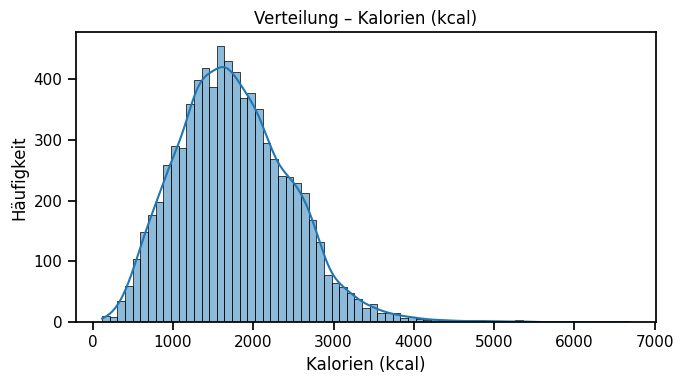

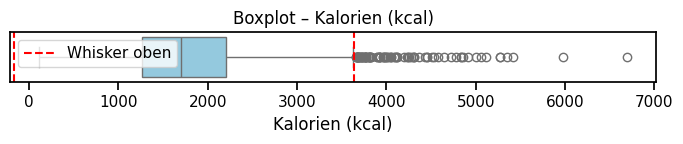

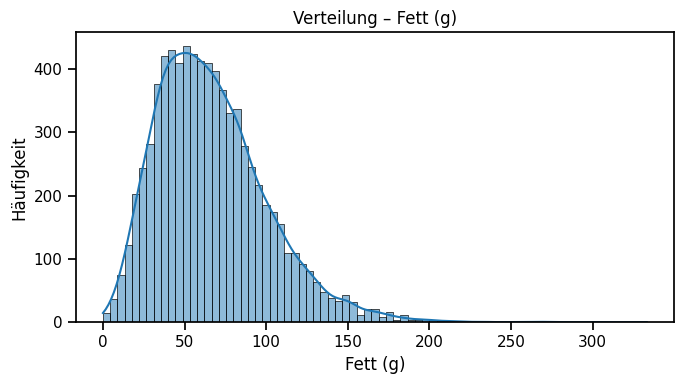

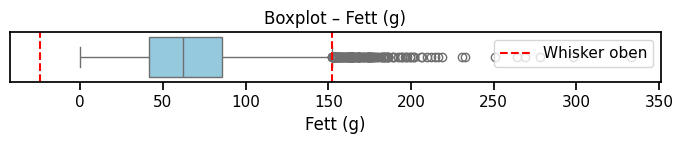

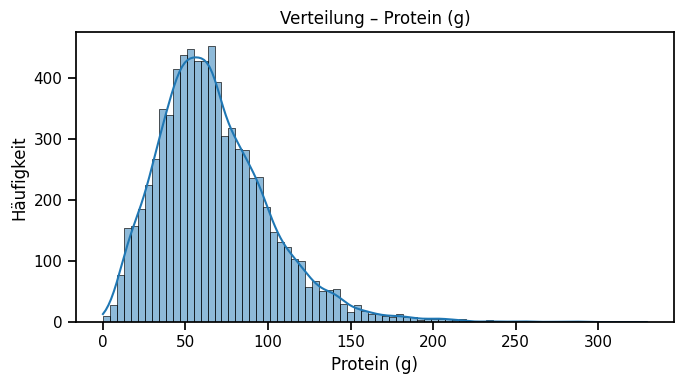

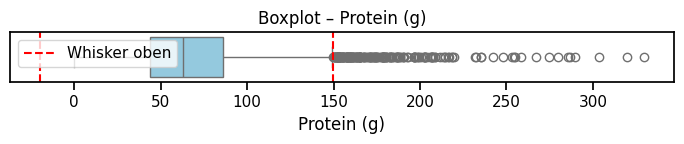

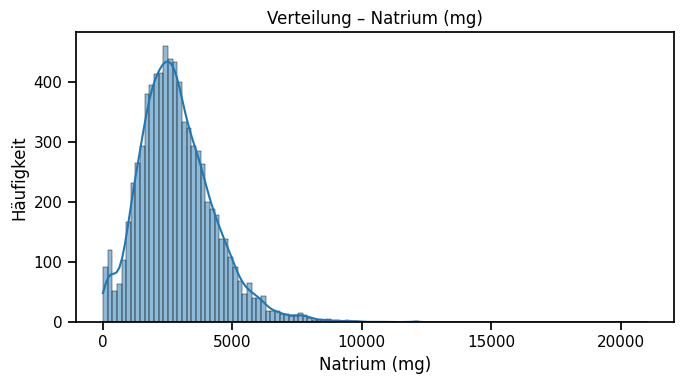

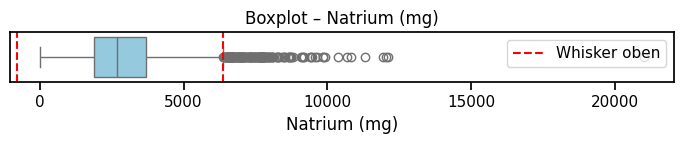

In [94]:
# -----------------------------------------------
# MASTER-PLOTTER  –  Verteilungen in df_final
# -----------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Nährwerte, die wir darstellen wollen
variablen = {
    'DR1TKCAL': 'Kalorien (kcal)',
    'DR1TTFAT': 'Fett (g)',
    'DR1TPROT': 'Protein (g)',
    'DR1TSODI': 'Natrium (mg)'
}

sns.set_context('notebook', font_scale=1.0)

for var, label in variablen.items():
    werte = df_final[var].dropna()

    # ---------- Histogramm + KDE ----------
    plt.figure(figsize=(7, 4))
    sns.histplot(werte, kde=True, bins='auto')
    plt.title(f"Verteilung – {label}")
    plt.xlabel(label)
    plt.ylabel("Häufigkeit")
    plt.tight_layout()
    plt.show()

    # ---------- Boxplot ----------
    q1, q3 = werte.quantile([.25, .75])
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr

    plt.figure(figsize=(7, 1.6))
    sns.boxplot(x=werte, color='skyblue')
    plt.axvline(upper, ls='--', c='red', label='Whisker oben')
    plt.axvline(lower, ls='--', c='red')
    plt.title(f"Boxplot – {label}")
    plt.xlabel(label)
    plt.yticks([])           # y-Achse ausblenden
    plt.legend()
    plt.tight_layout()
    plt.show()


# Datenbereinigung + Engineering

# Feature Engeneering

NHANES Datensatz

Engineering um fehlende BMI Wert aufzufüllen

In [82]:
#Feature Engeneering BMI: Fehlende BMI-Wert bei den 758 Datensätzen durch Körpergewicht und Körpergrösse berechnen

# Voraussetzung:
# - WHD010: Körpergröße in cm
# - WHD020: Körpergewicht in kg
# - BMXBMI: BMI (wenn vorhanden)

# Formel: BMI = Gewicht (kg) / (Größe in m)^2
def berechne_bmi(row):
    if pd.isna(row['BMXBMI']) and not pd.isna(row['WHD010']) and not pd.isna(row['WHD020']):
        groesse_m = row['WHD010'] / 100
        return row['WHD020'] / (groesse_m ** 2)
    return row['BMXBMI']

# Zähle vorher, wie viele BMI-Werte fehlen
missing_bmi_before = df['BMXBMI'].isna().sum()

# Wende die Berechnung an
df['BMXBMI'] = df.apply(berechne_bmi, axis=1)

# Zähle nachher, wie viele noch fehlen
missing_bmi_after = df['BMXBMI'].isna().sum()
recovered = missing_bmi_before - missing_bmi_after

print(f"BMI-Werte ergänzt: {recovered} von {missing_bmi_before} fehlenden Fällen")


BMI-Werte ergänzt: 79 von 758 fehlenden Fällen


Engineering Gesundheitszustand: Übergewicht, Bluthochdruck, Diabetes oder gesund

<ipython-input-83-e1d8d3aff373>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


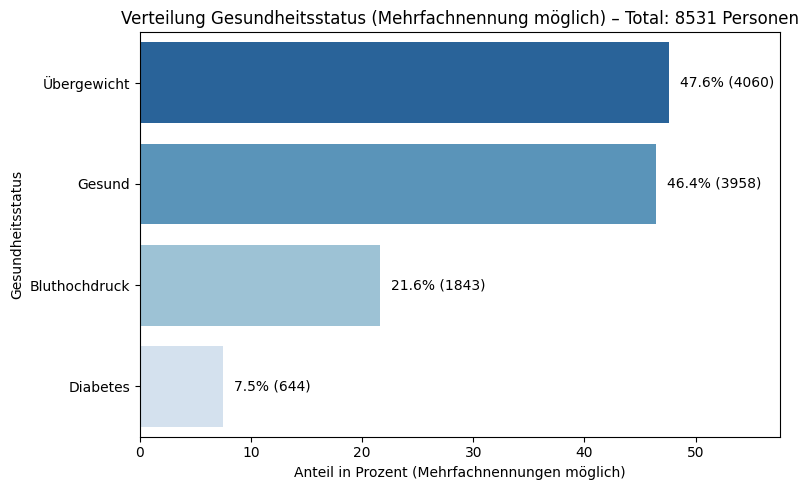

In [83]:
#Feature erstellen für Krankheiten - Übergewicht; Bluthochdruck und Diabetes
#es werden nur solche als gesund klassifiziert welche weder übergewichtig sind, oder an Bluthochdruck oder Diabetes leiden.
import matplotlib.pyplot as plt
import seaborn as sns

# Neue Diagnosefunktion – erlaubt mehrere Krankheiten pro Person
def get_diagnosen(row):
    diagnosen = []
    if row['DIQ010'] == 1:
        diagnosen.append('Diabetes')
    if row['BPXSY1'] >= 130 or row['BPXDI1'] >= 80:
        diagnosen.append('Bluthochdruck')
    if row['BMXBMI'] >= 25:
        diagnosen.append('Übergewicht')
    if not diagnosen:
        diagnosen.append('Gesund')
    return diagnosen

# Liste an Diagnosen pro Person erzeugen
df_bereinigt['diagnosen_liste'] = df_bereinigt.apply(get_diagnosen, axis=1)

# Jetzt alle Diagnosen in eine einzige Serie umwandeln und zählen
alle_diagnosen = df_bereinigt['diagnosen_liste'].explode()
diagnose_counts = alle_diagnosen.value_counts()
diagnose_percent = (diagnose_counts / len(df_bereinigt) * 100).round(1)

# Plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    y=diagnose_percent.index,
    x=diagnose_percent.values,
    orient='h',
    palette='Blues_r'
)

# Prozent- und Absolutwerte auf Balken schreiben
for i, (label, value) in enumerate(diagnose_percent.items()):
    abs_val = diagnose_counts[label]
    ax.text(value + 1, i, f"{value:.1f}% ({abs_val})", va='center')

# Titel & Achsen
gesamt = len(df_bereinigt)
plt.title(f"Verteilung Gesundheitsstatus (Mehrfachnennung möglich) – Total: {gesamt} Personen")
plt.xlabel("Anteil in Prozent (Mehrfachnennungen möglich)")
plt.ylabel("Gesundheitsstatus")
plt.xlim(0, max(diagnose_percent.values) + 10)
plt.tight_layout()
plt.show()


In [84]:
#Personen mit mehren "Krankheiten"
# Neue binäre Spalten für Auswertung erzeugen
df_bereinigt['übergewichtig'] = df_bereinigt['BMXBMI'] >= 25
df_bereinigt['bluthochdruck'] = (df_bereinigt['BPXSY1'] >= 130) | (df_bereinigt['BPXDI1'] >= 80)
df_bereinigt['diabetes'] = df_bereinigt['DIQ010'] == 1

# Kreuztabellen
pd.set_option('display.max_rows', None)  # alle Zeilen anzeigen

# Wie viele übergewichtige Personen haben zusätzlich Bluthochdruck oder Diabetes?
kombination = df_bereinigt.groupby('übergewichtig')[['bluthochdruck', 'diabetes']].sum()

# Zusätzlich: Gesamtanzahl in jeder Gruppe
anzahl_pro_gruppe = df_bereinigt['übergewichtig'].value_counts()

# Ausgabe als schöne Übersicht
print("Verteilung innerhalb der Übergewichts-Gruppen:\n")
print(kombination)
print("\nGesamtanzahl pro Gruppe (übergewichtig / nicht übergewichtig):")
print(anzahl_pro_gruppe)

# Optional: Prozentwerte berechnen
prozent = (kombination.T / anzahl_pro_gruppe.values).T.round(2)
print("\nAnteil innerhalb jeder Gruppe (in Prozent):")
print(prozent * 100)


Verteilung innerhalb der Übergewichts-Gruppen:

               bluthochdruck  diabetes
übergewichtig                         
False                    461        98
True                    1382       546

Gesamtanzahl pro Gruppe (übergewichtig / nicht übergewichtig):
übergewichtig
False    4471
True     4060
Name: count, dtype: int64

Anteil innerhalb jeder Gruppe (in Prozent):
               bluthochdruck  diabetes
übergewichtig                         
False                   10.0       2.0
True                    34.0      13.0


Engineering Klassifizieren von Raucher/nicht Rauchern

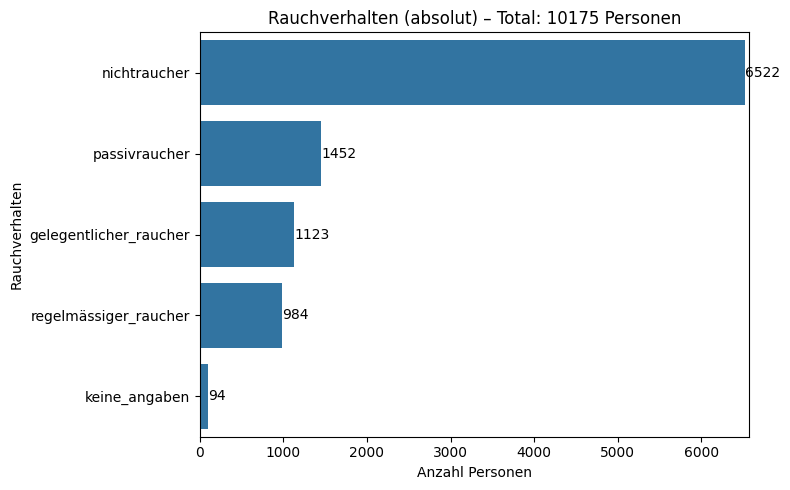

In [85]:
#Feature engeenering für Klassifikation von: "" nicht raucher, passiv Raucher, gelegenheits Raucher, regelmässiger Raucher"
#falls ein Person selbst raucht wird die Tatsache, dass sie/er allfällig in einem Haushalt lebt wo andere Personen ebenfalls rauchen vernachlässigt. Da dies gesundheitlich nicht mehr eine grosse Relevanz hat

def klassifiziere_raucher(row):
    smq621 = row.get("SMQ621")
    smq710 = row.get("SMQ710")
    smd460 = row.get("SMD460")

    if pd.isna(smq621) and pd.isna(smq710) and pd.isna(smd460):
        return "keine_angaben"

    if not pd.isna(smq710) and smq710 >= 3:
        return "regelmässiger_raucher"
    elif not pd.isna(smq710) and 1 <= smq710 <= 2:
        return "gelegentlicher_raucher"
    elif not pd.isna(smq621) and smq621 >= 100:
        return "regelmässiger_raucher"
    elif not pd.isna(smq621) and 1 <= smq621 < 100:
        return "gelegentlicher_raucher"
    elif not pd.isna(smd460) and smd460 >= 1:
        return "passivraucher"
    else:
        return "nichtraucher"

def klassifiziere_alkohol(row):
    alq110 = row.get("ALQ110")
    alq120q = row.get("ALQ120Q")

    if pd.isna(alq110) and pd.isna(alq120q):
        return "keine_angaben"

    if alq110 == 2:
        return "konsumiert_keinen_alkohol"

    if not pd.isna(alq120q):
        if alq120q == 0:
            return "konsumiert_keinen_alkohol"
        elif 1 <= alq120q <= 3:
            return "gelegentlich"
        elif 4 <= alq120q <= 6:
            return "regelmässig"
        elif alq120q >= 7:
            return "regelmässig_und_viel"

    return "keine_angaben"

# Neue Spalten erstellen
questionnaire["rauchverhalten_kategorie"] = questionnaire.apply(klassifiziere_raucher, axis=1)
questionnaire["alkoholkonsum_kategorie"] = questionnaire.apply(klassifiziere_alkohol, axis=1)

# Zähle die Kategorien
rauch_counts_abs = questionnaire["rauchverhalten_kategorie"].value_counts()
gesamt_anzahl_rauch = rauch_counts_abs.sum()

# Plot erstellen
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    y=rauch_counts_abs.index,
    x=rauch_counts_abs.values,
    orient="h",
    color="#1f77b4"  # Gleiche Farbe wie für Krankheiten
)

# Zahlen in Balken einfügen
for i, (label, value) in enumerate(rauch_counts_abs.items()):
    ax.text(value + 5, i, f"{value}", va="center", fontsize=10)

# Titel und Achsen
plt.title(f"Rauchverhalten (absolut) – Total: {gesamt_anzahl_rauch} Personen")
plt.xlabel("Anzahl Personen")
plt.ylabel("Rauchverhalten")
plt.xlim(0, max(rauch_counts_abs.values) + 50)
plt.tight_layout()
plt.show()


Engineering von Klassifizierungen im Bezug auf Alkoholkonsum

<ipython-input-86-43942d96fed1>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


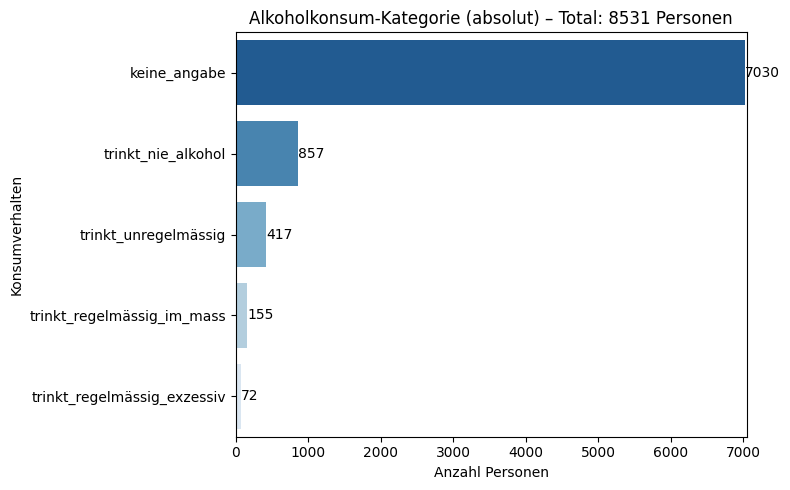

In [86]:
# Ziel: Personen systematisch in vier Gruppen einteilen basierend auf:
# - ob sie jemals Alkohol konsumiert haben (ALQ110)
# - wie häufig sie im letzten Jahr getrunken haben (ALQ120Q)
# - ob sie jemals eine Phase mit exzessivem Konsum hatten (ALQ151)
#
# Kategorien:
# - 'trinkt_nie_alkohol':      noch nie ≥12 Drinks im Leben (ALQ110 = 2)
# - 'trinkt_unregelmässig':    ALQ110 = 1, aber ALQ120Q ≤ 1x/Monat oder fehlt
# - 'trinkt_regelmässig_im_mass': ALQ110 = 1, ALQ120Q = 1–4x/Woche, keine Exzesse (ALQ151 ≠ 1)
# - 'trinkt_regelmässig_exzessiv': ALQ110 = 1, und ALQ151 = 1 oder ALQ120Q ≥ 5x/Woche

def klassifiziere_alkohol(row):
    if row['ALQ110'] == 2:
        return 'trinkt_nie_alkohol'
    elif row['ALQ110'] == 1:
        if pd.isna(row['ALQ120Q']):
            return 'trinkt_unregelmässig'  # keine Frequenzangabe trotz grundsätzlich Konsum
        elif row['ALQ120Q'] <= 1:
            return 'trinkt_unregelmässig'
        elif row['ALQ151'] == 1 or row['ALQ120Q'] >= 5:
            return 'trinkt_regelmässig_exzessiv'
        else:
            return 'trinkt_regelmässig_im_mass'
    return 'keine_angabe'

# Wende Klassifikation an
df_bereinigt['alkoholkonsum_kategorie'] = df_bereinigt.apply(klassifiziere_alkohol, axis=1)

# Berechne absolute Anzahl pro Kategorie
alkohol_counts_abs = df_bereinigt['alkoholkonsum_kategorie'].value_counts()
gesamt_anzahl = alkohol_counts_abs.sum()  # Gesamtzahl der klassifizierten Fälle

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    y=alkohol_counts_abs.index,
    x=alkohol_counts_abs.values,
    orient='h',
    palette='Blues_r'
)

# Zahlen auf Balken schreiben
for i, (label, value) in enumerate(alkohol_counts_abs.items()):
    ax.text(value + 1, i, f"{value}", va='center')

# Titel und Achsen
plt.title(f"Alkoholkonsum-Kategorie (absolut) – Total: {gesamt_anzahl} Personen")
plt.xlabel("Anzahl Personen")
plt.ylabel("Konsumverhalten")
plt.xlim(0, max(alkohol_counts_abs.values) + 20)
plt.tight_layout()
plt.show()

Kombination von Rauch- und Trinkverhalten

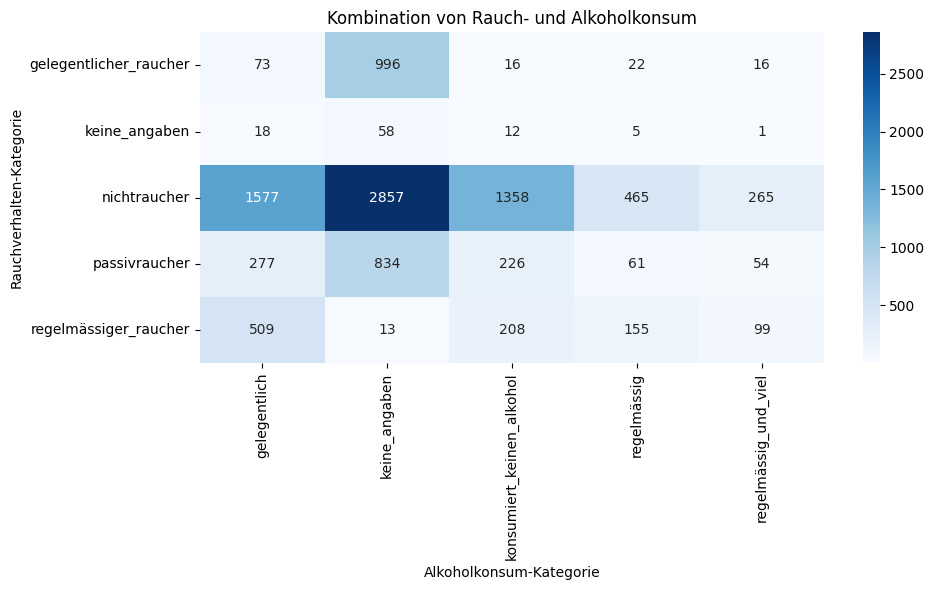

In [87]:
# Kreuztabelle erstellen
kreuz = pd.crosstab(
    questionnaire['rauchverhalten_kategorie'],
    questionnaire['alkoholkonsum_kategorie']
)

# Heatmap darstellen
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(kreuz, annot=True, fmt="d", cmap="Blues")
plt.title("Kombination von Rauch- und Alkoholkonsum")
plt.xlabel("Alkoholkonsum-Kategorie")
plt.ylabel("Rauchverhalten-Kategorie")
plt.tight_layout()
plt.show()


# KAQ 1: In welchen Ernährungsgewohnheiten liegt eine potenziell unausgewogene Nährstoffzufuhr vor?

**Erster exoloratives Clustering**
Bevor wir die Daten einem vordefinierten Kategorienschema unterwarfen, haben wir exploratives Clustering auf Basis der individuellen Nährstoffaufnahme durchgeführt. Der Abstand innerhalb der Punkt innerhalb des Cluster reduziert sich am stärksten zwischen 2-4 Cluster. Dementsprechend wir gehen wir von 3 Cluster aus. Der Silhouette Score von 0.244 zeigt jedoch auf, dass zwar Cluster vorhanden sind aber nicht sehr klar von einander trennbar sind.

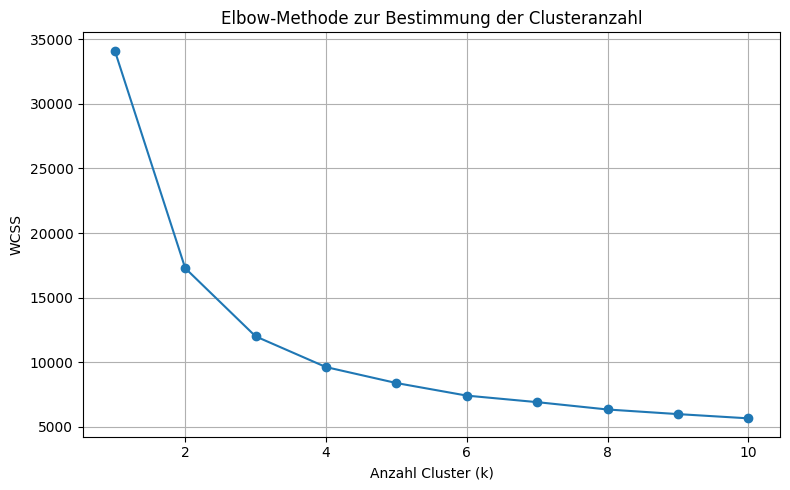

In [92]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# STEP 1: Cluster-relevante Spalten extrahieren
cluster_features = ['DR1TKCAL', 'DR1TTFAT', 'DR1TPROT', 'DR1TSODI']
df_cluster = df_bereinigt[cluster_features].dropna()

# STEP 2: Daten standardisieren
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# STEP 3: Elbow-Methode zur Bestimmung der optimalen Clusterzahl
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# STEP 4: Plot anzeigen
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow-Methode zur Bestimmung der Clusteranzahl")
plt.xlabel("Anzahl Cluster (k)")
plt.ylabel("WCSS")
plt.grid(True)
plt.tight_layout()
plt.show()


In [90]:
#Prüfen der Qualität bei verschieder Clusteranzahl von 2-10 Clustern (Cluster sind basierend auf standartisierten Rohdaten - nicht Differenzwerten)

from sklearn.preprocessing import StandardScaler

# Wähle die relevanten Features für Clustering
cluster_features = ['DR1TKCAL', 'DR1TTFAT', 'DR1TPROT', 'DR1TSODI']
df_cluster = df_bereinigt[cluster_features].dropna()

# Standardisierung
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Finde den besten k-Wert
for k in range(2, 11):  # von 2 bis 10 Cluster
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = model.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k={k}: Silhouette Score = {score:.3f}")


k=2: Silhouette Score = 0.497
k=3: Silhouette Score = 0.409
k=4: Silhouette Score = 0.353
k=5: Silhouette Score = 0.313
k=6: Silhouette Score = 0.290
k=7: Silhouette Score = 0.277
k=8: Silhouette Score = 0.261
k=9: Silhouette Score = 0.260
k=10: Silhouette Score = 0.247


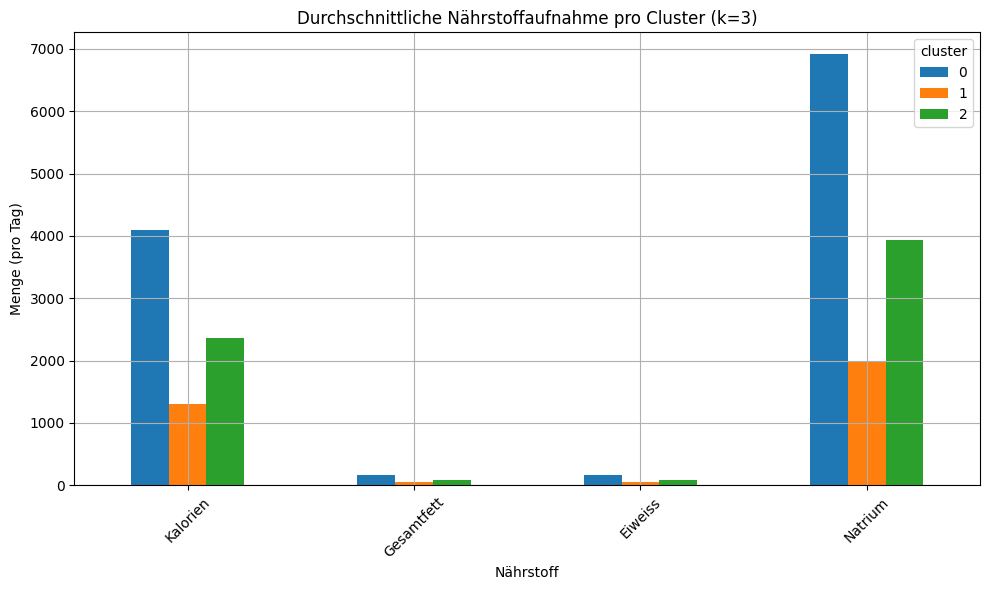

In [93]:
#Interpretation der Cluster k-3

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --- Cluster erstellen ---
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

# --- Originalnamen zu Klartext umbenennen ---
benennung = {
    'DR1TKCAL': 'Kalorien',
    'DR1TTFAT': 'Gesamtfett',
    'DR1TPROT': 'Eiweiss',
    'DR1TSODI': 'Natrium'
}

# --- Gruppiere nach Cluster und berechne Mittelwerte ---
cluster_bedeutung = df_cluster.groupby('cluster')[cluster_features].mean()
cluster_bedeutung.rename(columns=benennung, inplace=True)

# --- Transponieren für besseres Barplot ---
cluster_bedeutung.T.plot(kind='bar', figsize=(10, 6))
plt.title("Durchschnittliche Nährstoffaufnahme pro Cluster (k=3)")
plt.ylabel("Menge (pro Tag)")
plt.xlabel("Nährstoff")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

